##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License").

# Neural Machine Translation with Attention

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). This is an advanced example that assumes some knowledge of sequence to sequence models.

> このノートブックは [tf.keras](https://www.tensorflow.org/programmers_guide/keras) と [eager exicution](https://www.tensorflow.org/programmers_guide/eager) を使用してスペイン語を英語に翻訳するシーケンス to シーケンス（seq2seq）モデルを学習します。これはシーケンス to シーケンスモデルに関する知識があることを前提とした高度な例です。

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

> このノートブックでモデルを訓練した後は *"¿todavia estan en casa?"* などのスペイン語の文章を入力して、英語の翻訳 *"are you still at home?"* を返すことができます。

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

> 翻訳の質は例題としては妥当ですが、生成された Attention プロットはおそらくもっと興味深いものです。これは翻訳中に入力文のどの部分にモデルが注目したかを示します。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

> 注：この例では1台のP100 GPUで実行するのに約10分かかります。

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# Import TensorFlow >= 1.10 and enable eager execution
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
# tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print(tf.__version__)

2.0.0-beta1


In [0]:
from typing import List, Dict, Sequence, Tuple, Iterable

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

> http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには次の形式の言語翻訳ペアが含まれています。

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

> さまざまな言語がありますが、ここでは英語 - スペイン語のデータセットを使用します。便宜上、このデータセットのコピーをGoogle Cloudでホストしていますが、自分のコピーをダウンロードすることもできます。データセットをダウンロードした後、データを準備するための手順は次のとおりです。

1. Add a *start* and *end* token to each sentence.<br />各文に開始トークンと終了トークンを追加します。
2. Clean the sentences by removing special characters.<br />特殊文字を削除して文章をきれいにします。
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).<br />単語インデクスと逆単語インデクスを作成します（単語→id と id→単語 のマッピング辞書）。
4. Pad each sentence to a maximum length.<br />各文を最大長まで埋めます。

In [0]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin = 'http://storage.googleapis.com/'
        'download.tensorflow.org/data/spa-eng.zip', 
    extract = True)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s : str) -> str :
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w : str) -> str :
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931
    #     /python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path : str, num_examples : int) -> List[List[str]] :
    lines = open(path, encoding = 'UTF-8').read().strip().split('\n')
    
    word_pairs = [
        [preprocess_sentence(w) for w in l.split('\t')]
        for l in lines[:num_examples]
    ]
    
    return word_pairs

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang : Iterable[str]):
        self.lang = lang
        self.word2idx : Dict[str, int] = {}
        self.idx2word : Dict[int, str] = {}
        self.vocab = set()
    
        self.create_index()
    
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
    
        self.vocab = sorted(self.vocab)
    
        #self.word2idx['<pad>'] = 0
        #for index, word in enumerate(self.vocab):
        #    self.word2idx[word] = index + 1
        self.word2idx = { word : idx for idx, word in enumerate(self.vocab, 1) }
        self.word2idx['<pad>'] = 0

        #for word, index in self.word2idx.items():
        #    self.idx2word[index] = word
        self.idx2word = { idx : word for word, idx in self.word2idx.items() }


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path : str, num_examples : int):
    # creating cleaned input, output pairs
    pairs : List[List[str]] = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor : List[List[int]] = [
        [inp_lang.word2idx[s] for s in sp.split(' ')]
        for en, sp in pairs
    ]
    
    # English sentences
    target_tensor : List[List[int]] = [
        [targ_lang.word2idx[s] for s in en.split(' ')]
        for en, sp in pairs
    ]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp = max_length(input_tensor)
    max_length_tar = max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor : np.ndarray = tf.keras.preprocessing.sequence.pad_sequences(
        input_tensor,
        maxlen = max_length_inp,
        padding = 'post')
    
    target_tensor : np.ndarray = tf.keras.preprocessing.sequence.pad_sequences(
        target_tensor,
        maxlen = max_length_tar,
        padding = 'post')
    
    return (
        input_tensor, target_tensor,
        inp_lang, targ_lang,
        max_length_inp, max_length_tar)

> [pad_sequences](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

> 10万文を超える完全なデータセットのトレーニングには長い時間がかかります。より早く訓練するために、データセットのサイズを3万文に制限することができます（もちろん少ないデータでは翻訳品質が低下します）。

In [0]:
# Try experimenting with the size of that dataset
num_examples = 30000
(input_tensor, target_tensor, inp_lang, targ_lang,
 max_length_inp, max_length_targ) = load_dataset(path_to_file, num_examples)

In [0]:
# Creating training and validation sets using an 80-20 split
(input_tensor_train, input_tensor_val,
 target_tensor_train, target_tensor_val) = train_test_split(
    input_tensor,
    target_tensor,
    test_size = 0.2)

# Show length
(len(input_tensor_train), len(target_tensor_train),
 len(input_tensor_val), len(target_tensor_val))

(24000, 24000, 6000, 6000)

### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)

[from_tensor_slices](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensor_slices)

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input word is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

> ここでは TensorFlow [Neural Machine Translation(seq2seq) チュートリアル](https://github.com/tensorflow/nmt)で読むことができる、Attention付きエンコーダー - デコーダーモデルを実装します。この例ではより新しい一連の API を使用しています。このノートブックは seq2seq チュートリアルから [Attention 計算式](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)を実装します。次の図は、各入力単語に Attention メカニズムによって重みが割り当てられていることを示しています。このメカニズムは文章内の次の単語を予測するためにデコーダーによって使用されます。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

> 入力はエンコーダーモデルを通過します。これにより形状が  *(batch_size, max_length, hidden_size)* のエンコーダー出力と、形状が *(batch_size, hidden_size)* のエンコーダー隠れ状態が得られます。

Here are the equations that are implemented:

> これが実装される計算式です：

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

> 私たちは *Bahdanau attention* を使います。簡略形で書く前に表記法を決めましょう。

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

> そして擬似コードです。

* `score = FC(tanh(FC(EO) + FC(H)))`<br />
メモ：全結合層は入力と内部の重みの行列積を計算するレイヤのため、計算式中で $W_1$ や $v_a$ などの重みとの積の部分は `FC` により表現できる。ここで $h_t$ = `H`、$\bar{h}_s$ = `EO` 。
* `attention weights = softmax(score, axis = 1)`<br />
Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.<br />
Softmax はデフォルトでは最後の軸に適用されますが、ここではスコアの形状が *(batch_size, max_length, 1)* であるため、*1番目の軸* に適用します。 `Max_length` は私達の入力の長さです。各入力に重みを割り当てようとしているので softmax をその軸に適用する必要があります。
* `context vector = sum(attention weights * EO, axis = 1)`<br />
Same reason as above for choosing axis as 1.<br />1番目の軸を選択したのは上と同じ理由です。
* `embedding output` = The input to the decoder X is passed through an embedding layer.<br />デコーダーへの入力 X は埋め込み層を通過します。
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU<br />このマージされたベクトルは GRU に渡されます。
  
The shapes of all the vectors at each step have been specified in the comments in the code:

> 各ステップのすべてのベクトルの形状はコード内のコメントで指定されています。

In [0]:
def gru(units):
    # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
    # the code automatically does that.
    if tf.test.is_gpu_available() and False:
        # メモ：2019/07/04 tensorflow-gpu 2.0.0-beta1 に CuDNNGRUはない
        # return tf.keras.layers.CuDNNGRU(
        #    units,
        #    return_sequences = True,
        #    return_state = True,
        #    recurrent_initializer = 'glorot_uniform')
    else:
        return tf.keras.layers.GRU(
            units,
            return_sequences = True,
            return_state = True,
            recurrent_activation = 'sigmoid',
            recurrent_initializer = 'glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(
        self,
        vocab_size : int,  # 語彙数
        embedding_dim : int,  # 埋め込みレイヤで出力する密ベクトルの次元数
        enc_units : int,  # Encoder(のGRU）の出力次元数
        batch_sz : int) :  # バッチサイズ

        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    # 入力 x は int の ndarray を convert_to_tensor() したもの
    # 型としては tensorflow.python.framework.ops.EagerTensor …
    # hidden は初回は initialze_hidden_state で返却したものが渡ってくる
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

> [Embedding](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Embedding)
> <br />
> <br />Embedding レイヤは入力の整数値（単語ID）を固定長の密ベクトルに変換する。第1引数 input_dim は語彙数。第2引数 output_dim は出力する密ベクトルの次元数。

> [GRU](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/GRU)
> <br />
> <br />※GPUが使われる条件について抜粋※
> <br />利用可能なランタイムハードウェアと制約に基づいて、このレイヤーはパフォーマンス最大化のため異なる実装（cuDNNベースまたは純粋なTensorFlow）を選択します。 GPUが利用可能で、レイヤーに対するすべての引数がCuDNNカーネルの要件を満たす場合（詳細は下記を参照）、高速なcuDNN実装を使用します。
> <br />
> <br />cuDNN実装を使用するための要件は次のとおりです。
> <br />
> 1. activation == 'tanh'
> 1. recurrent_activation == 'sigmoid'
> 1. recurrent_dropout == 0
> 1. unroll is False
> 1. use_bias is True
> 1. reset_after is True
> 1. 入力がマスクされていないか、厳密に右詰めされている
> <br />メモ：1 ～ 6 は既定値のため、この入力値の条件さえ満たせば GPU が使われる

In [0]:
class Decoder(tf.keras.Model):
    def __init__(
        self,
        vocab_size : int,  # 語彙数
        embedding_dim : int,  # 埋め込みレイヤで出力する密ベクトルの次元数
        dec_units : int,  # GRU の出力次元数
        batch_sz : int) :  # バッチサイズ

        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis
        # because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(
            self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        # x shape after passing through embedding 
        # == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation
        # == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = real,
        logits = pred) * mask
    return tf.reduce_mean(loss_)

> [Adam](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers/Adam)
> <br />
> [sparse_softmax_cross_entropy_with_logits](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer = optimizer,
    encoder = encoder,
    decoder = decoder)

> [Checkpoint](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/train/Checkpoint)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
<br />出力と隠れ状態を返すエンコーダーに入力を渡します。
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
<br />エンコーダーの出力と隠れ状態、およびデコーダー入力（開始トークン）がデコーダに渡されます。
3. The decoder returns the *predictions* and the *decoder hidden state*.
<br />デコーダーは予測結果とデコーダー隠れ状態を返します。
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
<br />デコーダー隠れ状態がモデルに戻され、予測結果が損失の計算に使用されます。
5. Use *teacher forcing* to decide the next input to the decoder.
<br />デコーダーへの次の入力を決定するために *teacher forcing* を使用します。
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
<br />*Teacher forcing* は目標（正解）の単語を次の入力としてデコーダーに渡す手法です。
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.
<br />最後のステップは勾配を計算し、それをオプティマイザに適用して逆伝播することです。

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims(
                [targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(
                    dec_input,
                    dec_hidden,
                    enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print(f'Epoch { epoch + 1 } Batch { batch } '
                  f'Loss { batch_loss.numpy() :.4f}')

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print(f'Epoch {epoch + 1} Loss {total_loss / N_BATCH:.4f}')
    print(f'Time taken for 1 epoch { time.time() - start } sec\n')

Epoch 1 Batch 0 Loss 4.6996
Epoch 1 Batch 100 Loss 2.1855
Epoch 1 Batch 200 Loss 1.8083
Epoch 1 Batch 300 Loss 1.7019
Epoch 1 Loss 2.0081
Time taken for 1 epoch 89.5616569519043 sec

Epoch 2 Batch 0 Loss 1.6191
Epoch 2 Batch 100 Loss 1.4720
Epoch 2 Batch 200 Loss 1.3713
Epoch 2 Batch 300 Loss 1.3228
Epoch 2 Loss 1.3849
Time taken for 1 epoch 89.85656118392944 sec

Epoch 3 Batch 0 Loss 1.1686
Epoch 3 Batch 100 Loss 1.0518
Epoch 3 Batch 200 Loss 1.0033
Epoch 3 Batch 300 Loss 0.9391
Epoch 3 Loss 1.0059
Time taken for 1 epoch 88.45564079284668 sec

Epoch 4 Batch 0 Loss 0.8311
Epoch 4 Batch 100 Loss 0.7297
Epoch 4 Batch 200 Loss 0.6649
Epoch 4 Batch 300 Loss 0.6592
Epoch 4 Loss 0.6844
Time taken for 1 epoch 89.5451307296753 sec

Epoch 5 Batch 0 Loss 0.5639
Epoch 5 Batch 100 Loss 0.4717
Epoch 5 Batch 200 Loss 0.4463
Epoch 5 Batch 300 Loss 0.3966
Epoch 5 Loss 0.4504
Time taken for 1 epoch 88.97400498390198 sec

Epoch 6 Batch 0 Loss 0.3566
Epoch 6 Batch 100 Loss 0.3094
Epoch 6 Batch 200 Loss 0

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
<br />評価関数は *teacher forcing* を使用しないことを除いてトレーニングループと似ています。各時間ステップのデコーダーへの入力は、1つ前の予測値および隠れ状態とエンコーダー出力です。
* Stop predicting when the model predicts the *end token*.
<br />モデルが終了トークンを予測したら予測を停止します。
* And store the *attention weights for every time step*.
<br />そしてタイムステップごとに attention weights を保存します。

Note: The encoder output is calculated only once for one input.

> 注：エンコーダ出力は1つの入力に対して1回だけ計算されます。

In [0]:
def evaluate(
    sentence,
    encoder,
    decoder,
    inp_lang,
    targ_lang,
    max_length_inp,
    max_length_targ):

    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs],
        maxlen = max_length_inp,
        padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input,
            dec_hidden,
            enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap = 'viridis')
    
    fontdict = {'fontsize' : 10}
    
    ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(
    sentence,
    encoder,
    decoder,
    inp_lang,
    targ_lang,
    max_length_inp,
    max_length_targ):

    result, sentence, attention_plot = evaluate(
        sentence,
        encoder,
        decoder,
        inp_lang,
        targ_lang,
        max_length_inp,
        max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[
        :len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s too cold here . <end> 


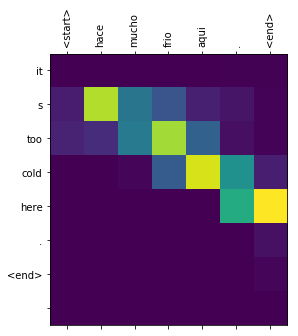

In [0]:
translate(u'hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


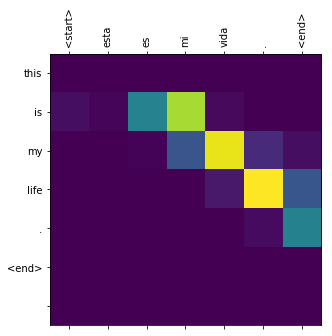

In [0]:
translate(u'esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> todavia estan en casa ? <end>
Predicted translation: are still home ? <end> 


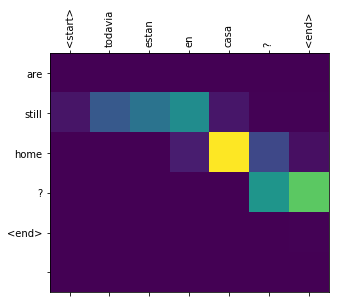

In [0]:
translate(u'todavia estan en casa?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it . <end> 


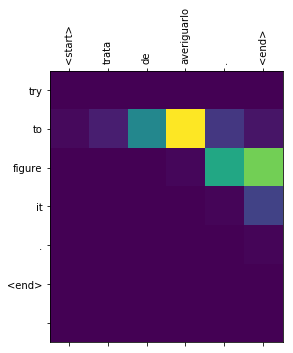

In [0]:
# wrong translation
translate(u'trata de averiguarlo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
<br />[別のデータセットをダウンロード](http://www.manythings.org/anki/)して、たとえば英語からドイツ語、または英語からフランス語への翻訳を試してください。
* Experiment with training on a larger dataset, or using more epochs
<br />より大きなデータセットでのトレーニング、またはより多くのエポックの使用を試してください。